In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from time import time
import seaborn as sns

sns.set_style("darkgrid")
import sys
import qss

### change this ###
sys.path.append("/Users/lukevolpatti/Documents/thesis/signal-decomposition/")
from gfosd import Problem
from gfosd.components import *

In [3]:
# Notebook-wide macros
SAVE = True

if SAVE:
    import matplotlib
    from matplotlib.backends.backend_pgf import FigureCanvasPgf

    matplotlib.backend_bases.register_backend("pdf", FigureCanvasPgf)
    sns.set_context("paper")
    matplotlib.rcParams["axes.unicode_minus"] = False
    # matplotlib.use("pgf")
    matplotlib.rcParams.update(
        {
            "pgf.texsystem": "pdflatex",
            "font.family": "serif",
            "text.usetex": True,
            "pgf.rcfonts": False,
        }
    )

# l1 trend filtering

## Data generation

In [4]:
T = int(1e5)
np.random.seed(42)
aa = T // 4
bb = T // 6
pwl = np.r_[
    np.linspace(0, 3, num=aa, endpoint=False),
    np.linspace(3, 1.5, num=bb, endpoint=False),
    np.linspace(1.5, -3, num=bb, endpoint=False),
    np.linspace(-3, -2.5, num=aa, endpoint=False),
    np.linspace(-2.5, 0, num=T - 2 * (aa + bb), endpoint=False),
]
noise = 0.2 * np.random.randn(T)
signal = pwl + noise
X_real = np.asarray([noise, pwl])
use_set = np.full(T, True)
use_set[: T // 5] = False
np.random.shuffle(use_set)
y = np.copy(signal)  # need signal for l1_tf
y[~use_set] = np.nan

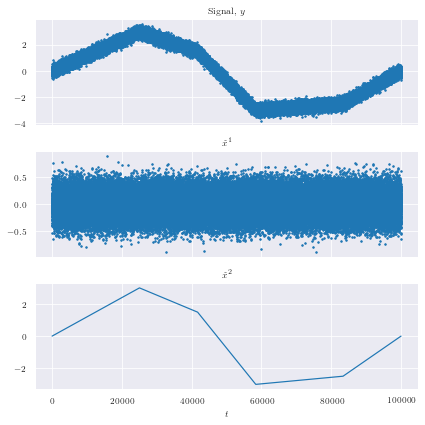

In [5]:
fig, ax = plt.subplots(
    nrows=3, sharex=True, figsize=(6, 6), rasterized=True
)  # (10, 8))
ax[0].scatter(np.arange(T), y, linewidth=0.9, s=2.5)
ax[1].scatter(np.arange(T), noise, linewidth=0.9, s=2.5)
ax[2].plot(pwl)
ax[0].set_title("Signal, $y$")
for i in range(X_real.shape[0]):
    ax[i + 1].set_title("$\\tilde{x}^{" + "{}".format(i + 1) + "}$")
ax[-1].set_xlabel("$t$")
plt.tight_layout()
if SAVE:
    plt.gcf().savefig("./l1-trend-data.pgf", dpi=250)

## Problem solution

### Signal decomposition via QSS

In [6]:
component1 = SumSquare(weight=70 / len(y))
component2 = SumAbs(weight=1, diff=2)
prob = Problem(y, [component1, component2])
prob.decompose(verbose=True, precond=False, eps_abs=1e-5, eps_rel=1e-5)

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      3.10e-01s

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 6.84e+01    1.78e+02     5.97e+01   [0.1 0.1]  2.45e-02
   25 | 3.06e+01    4.00e+00     5.55e-01   [0.1 0.1]  5.06e-01
   50 | 4.89e+00    1.57e+02     5.50e-04   [1.e+06 1.e-06]  1.13e+00
   75 | 1.12e+00    5.67e-04     3.19e-01   [1.e+06 1.e-06]  1.64e+00
  100 | 1.46e+00    9.90e-01     1.40e-02   [4.62253713e-01 1.00000000e-06]  2.25e+00
  125 | 1.14e+00    4.29e-03     2.12e-04   [4.62253713e-01 1.00000000e-06]  2.75e+00
  15

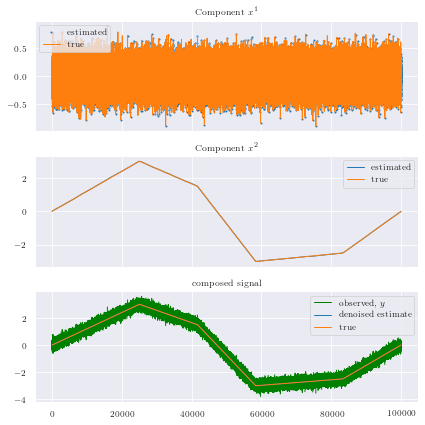

In [7]:
X_real = np.vstack([noise, pwl])
fig = prob.plot_decomposition(X_real=X_real, figsize=(6, 6), rasterized=True)
plt.tight_layout()
plt.show()
if SAVE:
    fig.savefig("./l1-trend-qss.pgf", dpi=250)

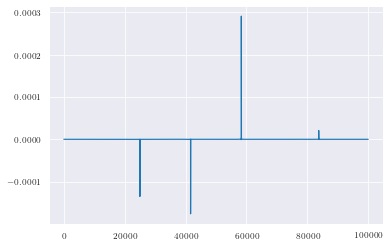

In [8]:
qss_res = prob.decomposition[1]
plt.plot(np.diff(qss_res, n=2))
if SAVE:
    plt.savefig("l1-trend-qss-second-diff.pgf")

### Signal decomposition via OSQP

In [9]:
prob.decompose(verbose=True, solver="OSQP", eps_abs=4.5e-8, eps_rel=4.5e-8)

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Aug 22 12:15:49 PM: Your problem has 299998 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 22 12:15:49 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 22 12:15:49 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 22 12:15:49 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 22 12:15:49 PM: Compiling problem (target solver=OSQP).
(CVXPY) Aug 22 12:15:49 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuf

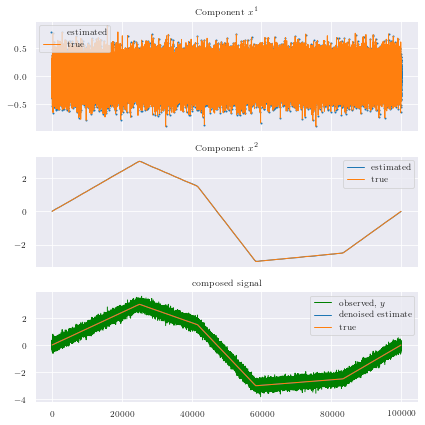

In [10]:
X_real = np.vstack([noise, pwl])
fig = prob.plot_decomposition(X_real=X_real, figsize=(6, 6), rasterized=True)
plt.tight_layout()
plt.show()
if SAVE:
    fig.savefig("./l1-trend-osqp.pgf", dpi=250)

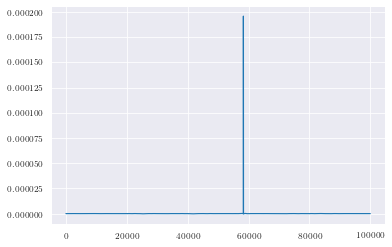

In [11]:
res = prob.decomposition[1]
plt.plot(np.diff(res, n=2))
if SAVE:
    plt.savefig("l1-trend-osqp-second-diff.pgf")

### Signal decomposition via masked proximal operators

In [12]:
from osd import Problem as OSDProblem
from osd.classes import MeanSquareSmall, SparseSecondDiffConvex

component1 = MeanSquareSmall(size=len(y), weight=70 / len(y))
component2 = SparseSecondDiffConvex(weight=1, solver="MOSEK")
prob = OSDProblem(y, [component1, component2])
prob.decompose(verbose=True)

Convex problem detected. Using BCD...
Starting BCD...
y shape: (100000,)
X shape: (2, 100000)

[====================] ...2 iterations, 7.10 sec -- obj_val: 8.52e-04, r: 1.29e-19, tol: 1.00e-05      



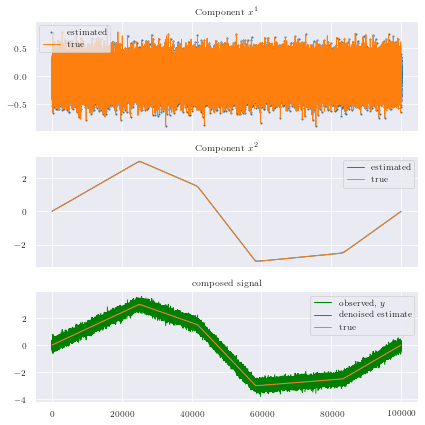

In [13]:
fig = prob.plot_decomposition(X_real=X_real, figsize=(6, 6), rasterized=True)
plt.legend()
if SAVE:
    fig.savefig("./l1-trend-osdv1.pgf", dpi=250)

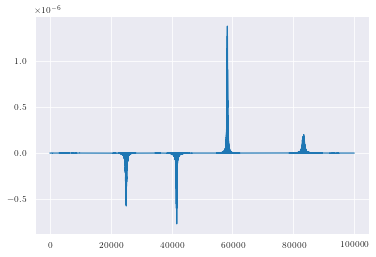

In [14]:
res = prob.components[1]
plt.plot(np.diff(res, n=2))
if SAVE:
    plt.savefig("l1-trend-osdv1-second-diff.pgf")

### l1_tf

In [15]:
import subprocess
import time

In [16]:
np.savetxt("signal.txt", signal, fmt="%f")
subprocess.call("make ./l1_tf/", shell=True)
start = time.time()
subprocess.call("./l1_tf/l1tf signal.txt " + str(T) + " > l1_tfres.txt", shell=True)
print(time.time() - start)
res = np.loadtxt("l1_tfres.txt")

make: Nothing to be done for `l1_tf/'.


--------------------------------------------
l1 trend filtering via primal-dual algorithm
C version 0.7 Aug 18 2007                   
Kwangmoo Koh, Seung-Jean Kim, Stephen Boyd
--------------------------------------------
data length         = 100000
lambda (lambda_max) = 1.000000e+05 (4.333612e+08)

Iteration   Primal obj.    Dual obj.      Gap
     0      3.9146e+09   0.00000e+00   3.91e+09
     1      5.5584e+05   1.96695e+03   5.54e+05
     2      1.0666e+05   1.98402e+03   1.05e+05
     3      9.3665e+03   1.99741e+03   7.37e+03
     4      2.4955e+03   2.00233e+03   4.93e+02
     5      2.1647e+03   2.01568e+03   1.49e+02
     6      2.1147e+03   2.04418e+03   7.05e+01
     7      2.1053e+03   2.05924e+03   4.61e+01
     8      2.0988e+03   2.06978e+03   2.90e+01
     9      2.0942e+03   2.07637e+03   1.78e+01
    10      2.0909e+03   2.07994e+03   1.10e+01
    11      2.0887e+03   2.08173e+03   6.93e+00
    12      2.0879e+03   2.08222e+03   5.66e+00
    13      2.0872e+03   2.

0.5256810188293457


Maxiter exceeded


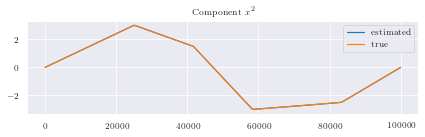

In [17]:
plt.figure(figsize=(6, 2))
plt.plot(res, label="estimated")
plt.plot(pwl, label="true")
plt.title("Component $x^2$")
plt.legend()
plt.tight_layout()
fig = plt.gcf()
plt.show()
if SAVE:
    fig.savefig("./l1-trend-l1tf.pgf")

In [18]:
m1 = sp.sparse.eye(m=T - 2, n=T, k=0)
m2 = sp.sparse.eye(m=T - 2, n=T, k=1)
m3 = sp.sparse.eye(m=T - 2, n=T, k=2)
D = m1 - 2 * m2 + m3

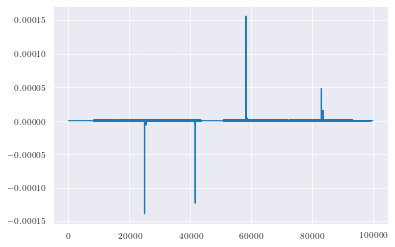

In [19]:
plt.plot(np.diff(res, n=2))
if SAVE:
    plt.savefig("l1-trend-l1tf-second-diff.pgf")

# Section 2.9 example

## Data generation

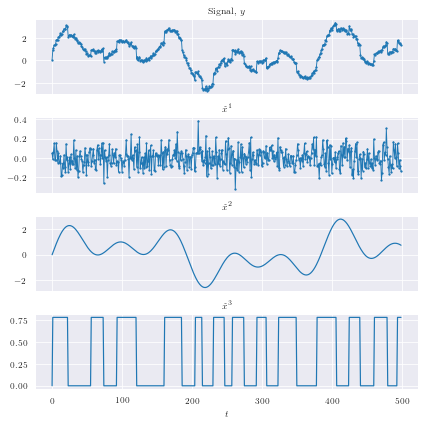

In [20]:
np.random.seed(42)

T = np.linspace(0, 1, 500)
scale = 0.7816 
rho = 0.75

x1_real = np.random.randn(len(T)) * 0.1

num_sines = 3
phases = np.random.uniform(low=0, high=2*np.pi, size=num_sines)
frequencies = np.random.uniform(low=1, high=5, size=num_sines)
params = zip(frequencies, phases)
x2_real = np.sum([np.sin(T * 2 * f * + ph) for f, ph in params], axis=0)

num_sines = 7
phases = np.random.uniform(low=0, high=2*np.pi, size=num_sines)
frequencies = np.random.uniform(low=30, high=32, size=num_sines)
params = zip(frequencies, phases)
x3_real = np.round(np.sign(np.sum([np.sin(T * 2 * f * + ph) for f, ph in params], axis=0)) / 2 + 0.5) * scale

X_real = np.array([x1_real, x2_real, x3_real])
y = np.sum(X_real, axis=0)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 6)) #(10, 8))
ax[0].plot(y, linewidth=0.9, marker='.', markersize=2.5)
ax[1].plot(x1_real, linewidth=0.9, marker='.', markersize=2.5)
ax[2].plot(x2_real)
ax[3].plot(x3_real)
ax[0].set_title('Signal, $y$')
for i in range(X_real.shape[0]):
    ax[i + 1].set_title('$\\tilde{x}^{'+'{}'.format(i + 1)+'}$')
ax[-1].set_xlabel('$t$')
plt.tight_layout()
if SAVE:
    plt.gcf().savefig('./section29-data.pgf')

## Problem solution

In [21]:
c1 = SumSquare(weight=10/len(y))
c2 = SumSquare(weight=1, diff=2)
c3 = FiniteSet(values={0, scale}, weight=1)
components = [c1, c2, c3]
prob = Problem(y, components)

### Signal decomposition via QSS

In [22]:
start = time.time()
prob.decompose(verbose=False, precond=True, adaptive_rho=False)
time.time() - start

1.6052947044372559

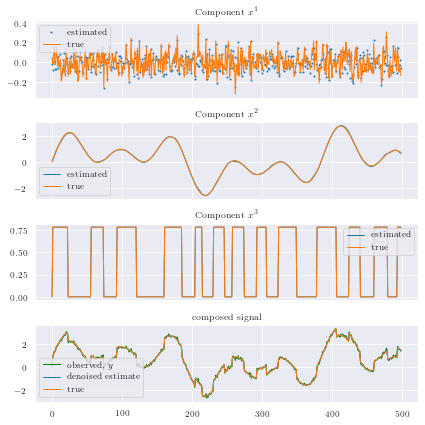

In [23]:
fig = prob.plot_decomposition(X_real=X_real, figsize=(6, 6))
plt.legend()
if SAVE:
    fig.savefig("./section29-qss.pgf")